## Extract trails
* This notebook will concatenate all epochs assoicated with a trail in to one data point.
* The goal of this is to try to describe data as a binary label
    * In other words a trail can be described as congruent or incongruent

In [136]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
import os

import mne
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

import time

from sklearn.preprocessing import StandardScaler, normalize

In [51]:
path = 'E:\EpochedEEG'
epoch_files = os.listdir(path)
file = os.path.join(path,epoch_files[0])
epoch = mne.read_epochs(file, preload = True)

Reading E:\EpochedEEG\20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [3]:
#UPDATES THE STIM CODE EVENT_IDS TO THEIR CORRECT VALUES
epoch = update_stim_code_event_ids(epoch)

In [4]:
epoch.event_id

{'trail_start': 31,
 'left_button': 131,
 'right_button': 132,
 'congruent': 133,
 'incongruent': 134,
 'correct': 129,
 'incorrect': 130,
 't_baby': 135,
 't_bell': 136,
 't_bird': 137,
 't_burp': 138,
 't_dog': 139,
 't_drum': 140,
 't_knock': 141,
 't_laugh': 142,
 't_phone': 143,
 't_train': 144,
 't_water': 145,
 'f_baby': 155,
 'f_bell': 156,
 'f_bird': 157,
 'f_burp': 158,
 'f_dog': 159,
 'f_drum': 160,
 'f_knock': 161,
 'f_laugh': 162,
 'f_phone': 163,
 'f_train': 164,
 'f_water': 165,
 'b-f2-wrd': 1,
 'b-f1-wrd': 2,
 'b-tg-wrd': 3,
 'b-f2-spk': 4,
 'b-f1-spk': 5,
 'b-tg-spk': 6,
 'b-f2-pic': 7,
 'b-f1-pic': 8,
 'b-tg-pic': 9,
 'b-f2-snd': 10,
 'b-f1-snd': 11,
 'b-tg-snd': 12,
 'f-f2-wrd': 13,
 'f-f1-wrd': 14,
 'f-tg-wrd': 15,
 'f-f2-spk': 16,
 'f-f1-spk': 17,
 'f-tg-spk': 18,
 'f-f2-pic': 19,
 'f-f1-pic': 20,
 'f-tg-pic': 21,
 'f-f2-snd': 22,
 'f-f1-snd': 23,
 'f-tg-snd': 24}

In [5]:
events = epoch.events[:,-1]
event_ids = epoch.event_id
print("len events:", len(events))

len events: 5424


In [6]:
epoch.get_data().shape

(5424, 129, 180)

In [8]:
#combining events of a trail into 1 list
trials = []
event_trial = []
start_index = 0
end_index = 0
for event in events:
    if event == 31 and event_trial != []:
        trials.append(event_trial)
        event_trial = []
        event_trial.append(event)
    else:
        event_trial.append(event)
print(np.array(trials)[:5])

[list([131]) list([31, 144, 162, 8, 3, 7, 132, 134, 130])
 list([31, 142, 162, 8, 3, 7, 132, 133, 129])
 list([31, 142, 162, 8, 3, 7, 132, 133])
 list([31, 142, 162, 8, 3, 7, 132, 133, 129])]


In [9]:
#combining events of a trail into 1 list
trials_1 = []
event_trial_1 = []
start_index = 0
end_index = 0
trial_index_list = []
for i in range(len(events)):
    if events[i] == 31 and event_trial != []:
        trial_index_list.append((start_index, end_index))
        trials_1.append(event_trial_1)
        event_trial_1 = []
        event_trial_1.append(events[i])
        start_index = i
        end_index +=1
    else:
        end_index +=1
        event_trial_1.append(events[i])
print(np.array(trials_1)[:5])

[list([131]) list([31, 144, 162, 8, 3, 7, 132, 134, 130])
 list([31, 142, 162, 8, 3, 7, 132, 133, 129])
 list([31, 142, 162, 8, 3, 7, 132, 133])
 list([31, 142, 162, 8, 3, 7, 132, 133, 129])]


In [11]:
events[trial_index_list[-1][0]:trial_index_list[-1][1]]

array([ 31, 141, 161,   2, 131,   9,   1, 132, 133, 129])

In [150]:
#create a list of dictionaries for trials where each dictionary
# contains the event_ids of a trial.
trials_and_events = []
trial_dict = {}
for trial in trials:
    for event in trial:
        for key, value in event_ids.items():
            if value == event:
                trial_dict[key] = event
    trials_and_events.append(trial_dict)
    trial_dict = {}
trials_and_events[:3]

[{'left_button': 131},
 {'trail_start': 31,
  't_train': 144,
  'f_laugh': 162,
  'b-f1-pic': 8,
  'b-tg-wrd': 3,
  'b-f2-pic': 7,
  'right_button': 132,
  'incongruent': 134,
  'incorrect': 130},
 {'trail_start': 31,
  't_laugh': 142,
  'f_laugh': 162,
  'b-f1-pic': 8,
  'b-tg-wrd': 3,
  'b-f2-pic': 7,
  'right_button': 132,
  'congruent': 133,
  'correct': 129}]

In [13]:
#remove dead trail at the beginning of study
# del trials_and_events[0]

###  Combine epochs by trail (event_ids are combined, but combining epochs is a different task)

### combine epochs and give them a label equal to Audio or Visual 

In [153]:
# creating a new dictionary where each trail will equal one of the values in the dictinary Mode_lexi that is defined in 
# ../preprocessing/StimCodes.ipynb
trial_event_ids = []
count = 0
for trial in trials_and_events:
    #check individual stim-codes and match them with corresponding combination defined in stimcodes.ipynb
    stim_combination = []
    
    for key in trial:
#         print(trial[key])
        if int(trial[key]) >= 1 and int(trial[key]) <= 24:
            stim_combination.append(trial[key])
#             print(stim_combination)
        if len(stim_combination) == 3: # stim-code combination complete, it can now be matched to a value in Mode_lexi
            stim_combination_tuple = (stim_combination[0],stim_combination[1],stim_combination[2])
#             print(stim_combination_tuple)
            
            try:#check if stim combination tuple is valid
                stim_combo_key = stim_combinations[stim_combination_tuple]
                dict = {stim_combo_key : trial}
                trial_event_ids.append(dict)
            except:
                print("stim cominbation {0} not valid".format(stim_combination_tuple))
                print(trial)
            break;
trial_event_ids[2]

stim cominbation (14, 21, 4) not valid
{'trail_start': 31, 't_water': 145, 'f_burp': 158, 'f-f1-wrd': 14, 'f-tg-pic': 21, 'b-f2-spk': 4, 'left_button': 131, 'incongruent': 134}


{'VVLN': {'trail_start': 31,
  't_laugh': 142,
  'f_laugh': 162,
  'b-f1-pic': 8,
  'b-tg-wrd': 3,
  'b-f2-pic': 7,
  'right_button': 132,
  'congruent': 133}}

In [146]:
trial_event_ids[0] #this trial has stim-code combination VVLN, which is a visual stimuli 
len(trial_event_ids)

638

## Event_ids are concatentated, but now I need to concatentate epochs
* This will be done by changing event_ids of a trial into a new event event_id that will describe all epochs in that trial. 

Trying a new method where I have one epoch object that will continuously be concatentated with another temporary epoch object.

In [170]:
#new Event_ids
modality_lexicality_event_ids = {
   "AALL" : 112,
   "AALN" : 212,
   "AANL" : 312,
   "AANN" : 412,
   "AVLL" : 512,
   "AVNN" : 612,
   "VALL" : 712,
   "VANN" : 812,
   "VVLL" : 912,
   "VVLN" : 1012,
   "VVNL" : 1112,
   "VVNN" : 1212
}

Use mne.merge_events to combine events

In [105]:
copy_epoch = epoch.copy()
# need a to  assign events of a trial to a temporary list
# have a master list to append temporary list to.
merged_events = []
time_start = time.time()
for i in range(len(trial_index_list)):
    start, end = trial_index_list[i]
    print(i,start,end)
    temp_epoch = copy_epoch[start:end]
    temp_events = temp_epoch.events
#     print(temp_events)
#     print(trial_event_ids[i].keys())
#     print(list(trial_event_ids[i].keys())[0])
#     print(modality_lexicality_event_ids[list(trial_event_ids[i].keys())[0]])
    temp_merged_events = mne.merge_events(temp_events,temp_events[:,-1],
                                          modality_lexicality_event_ids[list(trial_event_ids[i].keys())[0]],replace_events= True)
#     print(temp_merged_events)
    merged_events.append(temp_merged_events)
    temp_merged_events = []
    time_end = time.time()
print("time elapsed:", time_end - time_start)
print("merged_events:",merged_events)

0 0 1
1 1 10
2 10 19
3 19 27
4 27 36
5 36 44
6 44 52
7 52 60
8 60 68
9 68 76
10 76 84
11 84 92
12 92 101
13 101 110
14 110 119
15 119 128
16 128 136
17 136 145
18 145 153
19 153 161
20 161 170
21 170 179
22 179 187
23 187 195
24 195 204
25 204 213
26 213 222
27 222 230
28 230 238
29 238 247
30 247 255
31 255 263
32 263 271
33 271 280
34 280 289
35 289 297
36 297 305
37 305 313
38 313 321
39 321 330
40 330 339
41 339 348
42 348 357
43 357 365
44 365 373
45 373 381
46 381 390
47 390 399
48 399 407
49 407 415
50 415 423
51 423 431
52 431 439
53 439 448
54 448 456
55 456 464
56 464 472
57 472 481
58 481 489
59 489 498
60 498 507
61 507 515
62 515 523
63 523 532
64 532 540
65 540 549
66 549 557
67 557 566
68 566 574
69 574 582
70 582 590
71 590 599
72 599 607
73 607 616
74 616 625
75 625 633
76 633 642
77 642 650
78 650 658
79 658 667
80 667 676
81 676 685
82 685 694
83 694 702
84 702 710
85 710 718
86 718 727
87 727 735
88 735 744
89 744 752
90 752 760
91 760 769
92 769 778
93 778 786
94 7

IndexError: list index out of range

In [154]:
def get_stim_code_combination(epoch_object,stim_combinations_dict):
    stim_codes = []
    for event in epoch_object.events[:,-1]: #iterate over event_ids
        if event >= 1 and event <= 24:
            stim_codes.append(event)
            if len(stim_codes) == 3:
                stim_codes_tuple = (stim_codes[0],stim_codes[1],stim_codes[2])
                return stim_combinations[stim_codes_tuple]
    return "NaN"

In [196]:
copy_epoch = epoch.copy()
new_events_master = []
for i in range(len(trial_index_list)): # iterate through trial index list
    # extract start and end index
    try:
        start = trial_index_list[i][0]
        end = trial_index_list[i][1]

        #initialize temp epoch object between start - end indices
        temp_epoch = copy_epoch[start:end]
#         print(temp_epoch)
        # get temp epoch events
        temp_epoch_events = temp_epoch.events
        temp_epoch_event_ids = temp_epoch_events[:,-1]
        stim_code_key = get_stim_code_combination(temp_epoch, stim_combinations)

#         print(type(stim_code_key))
        new_event_id = modality_lexicality_event_ids[stim_code_key]
#         print(new_event_id)
#         try:
        temp_epoch_merged_events = mne.merge_events(temp_epoch_events,
                                                    temp_epoch_event_ids,
                                                    new_event_id,
                                                    replace_events = True)
#         except:
#             print("Could not merge events")
#         try:
        new_events_master.append(temp_epoch_merged_events)
#         except:
#             print("Could not append merged events")

    except:
        print("Could not find stim-code combination.")
        print("Meta: stim-combo-key: {0}".format(stim_code_key))
        

Could not find stim-code combination.
Meta: stim-combo-key: NaN
Could not find stim-code combination.
Meta: stim-combo-key: VVNL


In [199]:
# np_new_events_master = np.array(new_events_master).reshape(-1,1)
concat_events = np.concatenate([x for x in new_events_master])

In [201]:
epoch.events = concat_events
epoch.event_id = modality_lexicality_event_ids

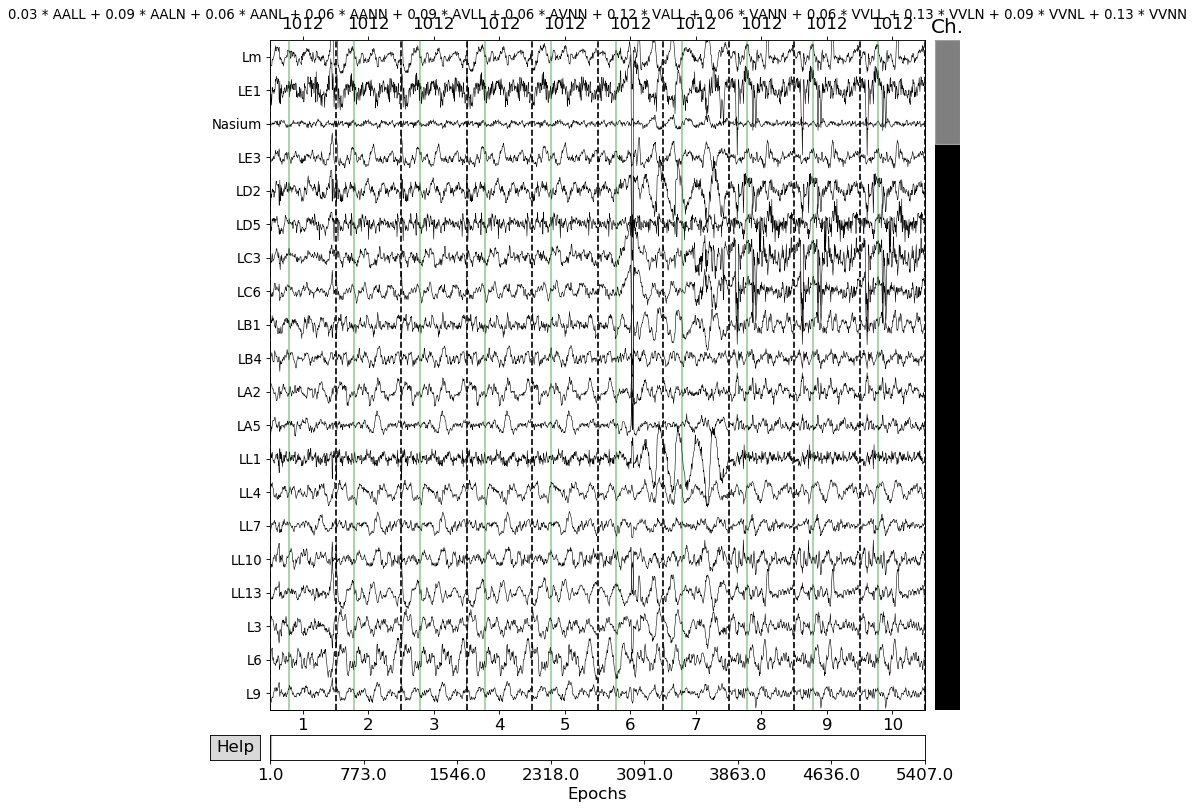

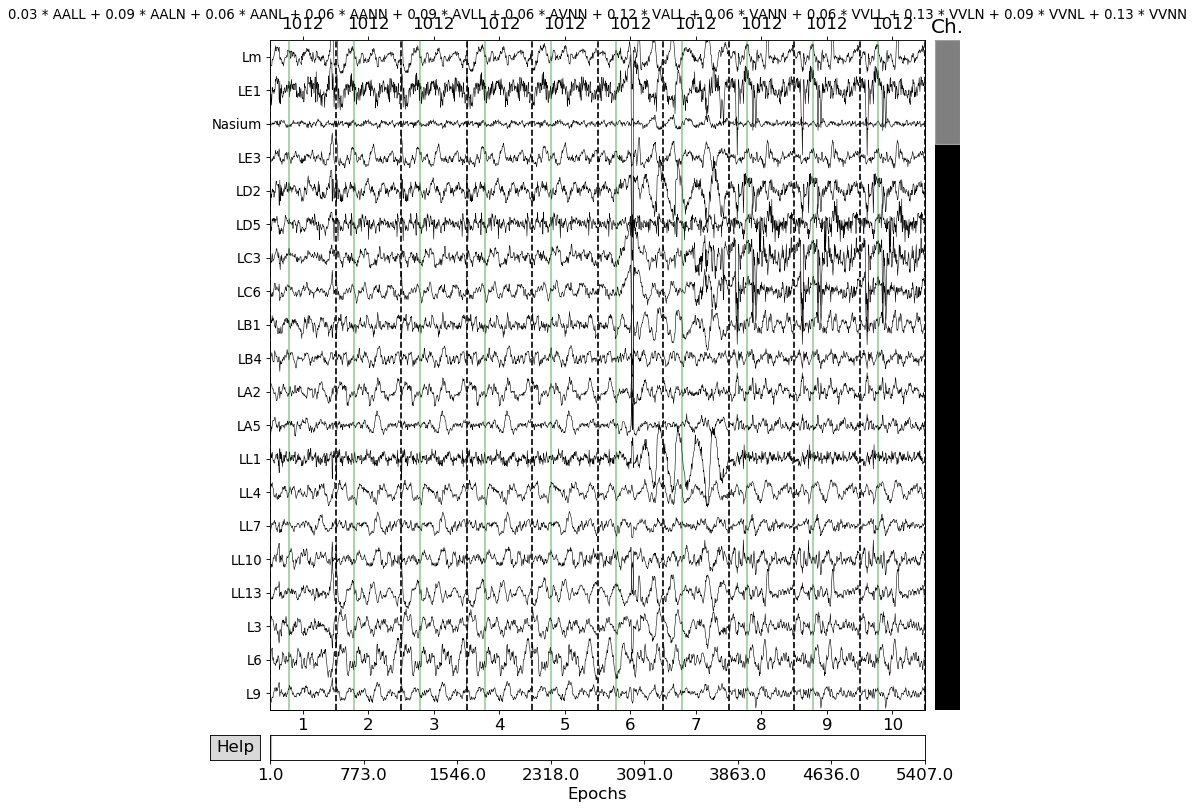

In [202]:
epoch.plot(n_epochs=10);